# Analysis of baseline models v1



In [21]:
import pickle
import joblib
from pandas import DataFrame, read_csv
import glob
from multigrids import TemporalMultiGrid, TemporalGrid
import os
from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.abspath('../forestpy/forestpy'))
import random_forest_tools as tools

In [2]:
data_dir = "/Users/rwspicer/Desktop/data/V1/"
feature_file = os.path.join(
    data_dir,
    "master-project/training/ACP/v2/baseline/multigrid/ACP-training-base.yml"
)
label_file = os.path.join(
    data_dir,
    "thermokarst/initiation-regions/ACP/v4/PDM-5var/without_predisp/multigrid/ACP-TKI-PDM5.yml"
)

to_td = lambda x: timedelta(hours = int(x.split(':')[0]),minutes = int(x.split(':')[1]), seconds = float(x.split(':')[2]))
to_seconds = lambda x: int(x.split(':')[0]) *60 *60 + int(x.split(':')[1]) * 60 + float(x.split(':')[2])
to_min = lambda x: to_seconds(x) / 60
to_hour = lambda x: to_min(x) / 60




In [5]:
training_data = TemporalMultiGrid(feature_file)
om = TemporalGrid(label_file)

list_of_models = [
#     'rfm_e2_md2_mfAUTO_msl8_mss5_tdp25.yml',
    
    'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25.yml',
    'rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50.yml',
    'rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50.yml',
    'rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25.yml',
    'rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25.yml',
    'rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75.yml',
    'rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75.yml',
]

model_files = glob.glob('../baseline-models/*.joblib')

In [14]:
model_files = sorted(model_files)
model_files = model_files[0:6] + model_files[7:]

In [9]:
def show_feature_importances(model, feature_list, show=False):
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance*100, 3)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    if show:
        [print('{:20} {}%'.format(*pair)) for pair in feature_importances];
        
    feature_importances = {f[0]:f[1] for f in feature_importances} 
    return feature_importances


grid_names = ['fdd', 'tdd', 'tdd+1', 'ewp', 'fwp', 'sp', 'lsp', 'sp+1', 'lat', 'long','aspect','slope', 'elev' ]

feature_importance_list = []
order = []
for fp in model_files:
    model = joblib.load(fp)
    order.append(os.path.split(fp)[1].replace('joblib','yml'))
    feature_importance_list.append(show_feature_importances(model, grid_names))

In [16]:
DataFrame(feature_importance_list, index = order)[1:].to_csv('../results/baseline-models-fi-v1.csv')

In [53]:
import numpy as np


ms = {}
for fp in model_files:
    s = {}
    model = joblib.load(fp)
    model.verbose = 0
    for y in range(1900,2020,5):
        new = tools.apply_model_to_year(model, training_data, y, training_data.config['mask'])
        
        s[y] = np.nanmean(np.abs(new - om[y]))
    ms[os.path.split(fp)[-1].split('.')[0]] = s
    
    

In [166]:
data = DataFrame(ms)
order = [
'rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75',         
'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75',
'rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75',
'rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25',
'rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25',
'rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50',
'rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50',
'rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50',
'rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25',
'rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25',
'rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25',
]
data = data.T.loc[order]
data['Candidate'] = [ str(i) for i in range(1,12) ]
data = data.set_index('Candidate')
data = data[data.columns[1:-1]]
data.T

Candidate,1,2,3,4,5,6,7,8,9,10,11
1905,1.888223,1.888223,1.905425,1.907239,1.877817,1.927964,1.927964,1.940959,2.867532,2.867263,2.862704
1910,1.393067,1.393067,1.406765,1.392940,1.367255,1.416609,1.416609,1.431508,1.917603,1.917964,1.910368
1915,1.707448,1.707448,1.732675,1.707389,1.662293,1.706748,1.706748,1.729944,2.370224,2.370789,2.362147
1920,1.017236,1.017236,1.020779,1.054837,1.065116,1.082016,1.082016,1.080586,1.421171,1.422320,1.424070
1925,1.539721,1.539721,1.557143,1.541329,1.528591,1.586656,1.586656,1.601436,1.500603,1.501046,1.495117
1930,1.020585,1.020585,1.028380,1.085329,1.085863,1.061630,1.061630,1.067020,1.680309,1.680865,1.678642
1935,0.948709,0.948709,0.957450,0.980221,0.965275,0.995467,0.995467,0.998039,1.112064,1.112529,1.108064
1940,1.032876,1.032876,1.035966,1.077688,1.086694,1.082972,1.082972,1.080501,1.359475,1.360498,1.366856
1945,1.058693,1.058693,1.065811,1.066423,1.055871,1.100259,1.100259,1.107853,1.358207,1.358293,1.351408
1950,1.182352,1.182352,1.191080,1.250076,1.250466,1.240312,1.240312,1.241955,1.554042,1.554343,1.555086


Text(0.5, 0, 'Year')

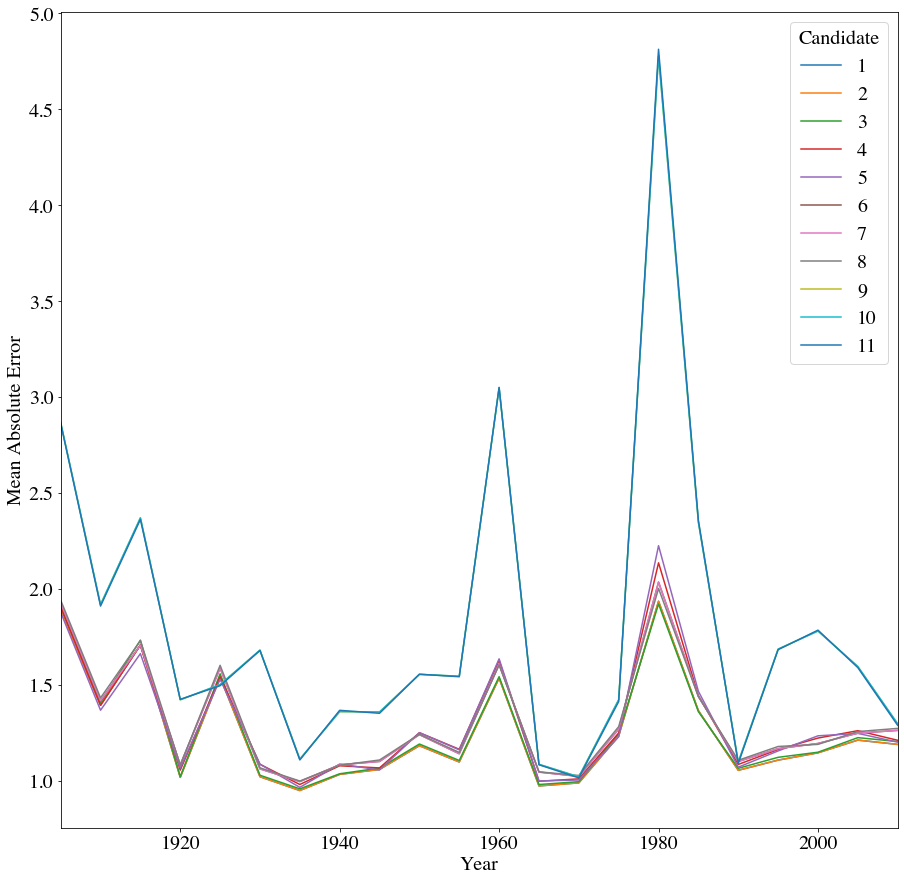

In [163]:
import matplotlib.pyplot as plt

from scipy import optimize
import numpy as np

from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams['font.serif'] = ['Times']
rcParams['font.size'] = 20

import matplotlib.pyplot as plt
fix, axes = plt.subplots(1, figsize=(15,15))

data.T.plot(ax = axes , legend=True, xlim=(1905, 2010))
# data.T.plot(ax = axes[1] , legend=False, ylim=(.9,2), xlim=(1905,1950))

axes.set_ylabel("Mean Absolute Error")
axes.set_xlabel("Year")

In [51]:
DataFrame(ms).mean()

rfm_e100_md25_mfAUTO_mln50000_msl2_mss2_tdp25     7.557430
rfm_e100_md25_mfAUTO_mln50000_msl2_mss5_tdp25     7.557518
rfm_e100_md25_mfAUTO_mln50000_msl4_mss10_tdp25    7.555263
rfm_e10_md100_mfAUTO_mln50000_msl4_mss10_tdp50    7.999046
rfm_e10_md60_mfAUTO_mln50000_msl8_mss2_tdp50      8.001491
rfm_e10_md60_mfAUTO_mln50000_msl8_mss5_tdp50      8.001491
rfm_e50_md100_mfAUTO_mln50000_msl8_mss5_tdp75     7.983561
rfm_e50_md60_mfAUTO_mln50000_msl2_mss10_tdp75     7.979955
rfm_e50_md60_mfAUTO_mln50000_msl4_mss5_tdp25      7.970104
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp25      7.967616
rfm_e50_md60_mfAUTO_mln50000_msl8_mss5_tdp75      7.983561
dtype: float64